# Using Virtual Training Data to Fine-tune Real-World Wildfire Smoke Detection

**Author:** Parker Addison  
**Date:** 2022-September – 2022-December

In this notebook, we conduct experimentation to evaluate whether it is effective to fine-tune a real-data computer vision training set with virtual data created via consumer-grade computer graphics simulations. Can providing a model additional *virtual* training data carefully crafted to resemble the target task yield comparable benefit to predictive performance as would providing addition *real* data?

This use-case and dataset relates to the paper *FIgLib & SmokeyNet: Dataset and Deep Learning Model for Real-Time Wildland Fire Smoke Detection* by Dewangan et al. (2022) https://www.mdpi.com/2072-4292/14/4/1007.

## Experiments

We'll conduct training on real versus real+virtual many times in order to get statistically robust results.

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import ConcatDataset, DataLoader, random_split
from tqdm import tqdm

import src.data
import src.models
import src.utils

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
num_repetitions = 30
num_epochs = 8
base_size = 250
augment_size = 250
loader_kwargs = {
    'batch_size': 64
}
backbone = 'resnet18'

source = 'data/EXAMPLE/transformed'
train_loader = src.data.load_tensors_from_folder(Path(source, 'train'), **loader_kwargs)
valid_loader = src.data.load_tensors_from_folder(Path(source, 'valid'), **loader_kwargs)
holdout_loader = src.data.load_tensors_from_folder(Path(source, 'holdout'), **loader_kwargs)
virtual_loader = src.data.load_tensors_from_folder(Path(source, 'virtual'), **loader_kwargs)

results = []
time_start = time.time()
for rep in range(num_repetitions):

    run_id = int(time.time())

    # Create data splits for training which we want to compare across
    base_trainset, aug_trainset, _ = random_split(
        train_loader.dataset,
        [base_size, augment_size, len(train_loader.dataset) - (base_size + augment_size)]
    )
    aug_virtset, _ = random_split(
        virtual_loader.dataset,
        [augment_size, len(virtual_loader.dataset) - augment_size]
    )
    experiments = [
        # n Real
        {
            'loader': DataLoader(base_trainset, **loader_kwargs),
            'meta': {'run': run_id, 'flag': 'Base', 'base_size': base_size, 'aug_size': 0}, 
        },
        # n Real + m Virtual
        {
            'loader': src.data.combine([base_trainset, aug_virtset], **loader_kwargs),
            'meta': {'run': run_id, 'flag': 'Virtual', 'base_size': base_size, 'aug_size': augment_size}, 
        },
        # n Real + m Real
        {
            'loader': src.data.combine([base_trainset, aug_trainset], **loader_kwargs),
            'meta': {'run': run_id, 'flag': 'Real', 'base_size': base_size, 'aug_size': augment_size}, 
        },
    ]

    # For each loader, train the model and save its metrics against the holdout set
    time_exp = time.time()
    with tqdm(experiments, desc=f"Repetition {rep+1}") as texp:

        for ex in texp:
            model, device, criterion, optimizer = src.models.initialize_model(backbone)
            src.models.train(model, ex['loader'], valid_loader, criterion, optimizer, epochs=num_epochs, disable_progress=True)
            metrics = src.models.evaluate(model, holdout_loader, criterion)
            results.append({**ex['meta'], **metrics})

            texp.set_postfix(time=src.utils.get_elapsed(time_exp), elapsed=src.utils.get_elapsed(time_start))



In [ ]:
# Save the results
results_file = Path('data/results.csv')

if not results_file.exists():
    _df = pd.DataFrame(columns=['flag', 'base_size', 'aug_size', 'loss', 'acc', 'auc', 'f1', 'prec', 'rec'])
    _df.to_csv(results_file, index=False)

_resdf = pd.DataFrame.from_records(results)
_currdf = pd.read_csv(results_file)
_df = pd.concat([_currdf, _resdf])
_df.to_csv(results_file, index=False)

## Analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

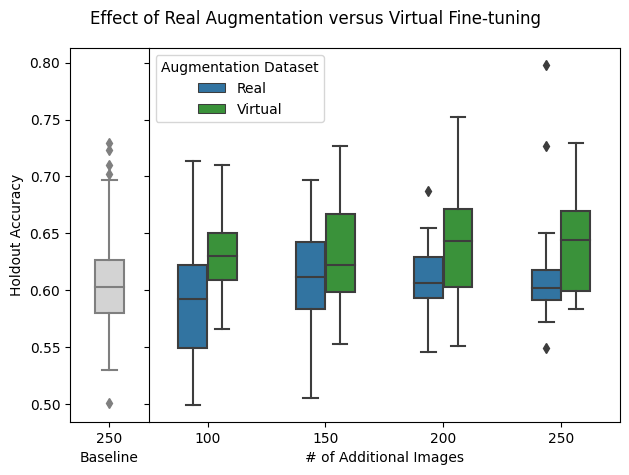

In [12]:
df = pd.read_csv('data/results.csv')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, width_ratios=[1,6], gridspec_kw={'wspace': 0})
w = 0.5
# Baseline boxplot
sns.boxplot(
    ax=ax1, data=df[df.flag=='Base'], width=w/2*1.5,
    color='lightgrey', x='aug_size', y='acc')
ax1.set_xlabel('Baseline')
ax1.set_xticklabels([250])
ax1.set_ylabel('Holdout Accuracy')
ax1.spines['right'].set_visible(False)
# Real and Virtual comparison
sns.boxplot(
    ax=ax2, data=df[df.flag!='Base'].sort_values('flag'), width=w,
    palette=['tab:blue', 'tab:green'],
    hue='flag', x='aug_size', y='acc')
legend = ax2.get_legend()
legend.set_title('Augmentation Dataset')
# legend.remove()  # remove for slide copy
ax2.set_xlabel('# of Additional Images')
ax2.set_ylabel(None)
plt.suptitle('Effect of Real Augmentation versus Virtual Fine-tuning')
plt.tight_layout()

Conduct a hypothesis test exploring if the improvement to target accuracy from the virtually fine-tuned model versus real is significant.
$$
H_0: \mu_\text{Virtual} = \mu_\text{Real} \\
H_1: \mu_\text{Virtual} > \mu_\text{Real}
$$

In [13]:
from scipy import stats

First we'll check if we meet assumptions for a paired student's t-test.

In [14]:
# Is it normal? (Across all trials)
stats.shapiro(df[df.flag=='Virtual'].acc)

ShapiroResult(statistic=0.979670524597168, pvalue=0.03503067046403885)

Since we slightly violate the normality assumption, we'll continue with the non-parametric Wilcoxon Signed-Rank test instead.

In [15]:
stats.wilcoxon(df[df.flag=='Virtual'].acc, df[df.flag=='Real'].acc, alternative='greater')

WilcoxonResult(statistic=7766.5, pvalue=1.9306792887051424e-09)

With an incredibly miniscule p-value, it's safe to say that we *reject* the null, in favor of an alternative suggesting that the fine-tuning on the virtual set produced significantly higher target accuracies than augmenting with additional real data!

In [11]:
# H0: mean(Real) = mean(Baseline); H1: mean(Real) != mean(Baseline)
stats.wilcoxon(df[df.flag=='Real'].acc, df[df.flag=='Base'].acc, alternative='two-sided')

WilcoxonResult(statistic=4805.5, pvalue=0.9004404618825531)